In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import tensorly as tl
from tlviz.factor_tools import factor_match_score
import seaborn as sns
import matcouply.decomposition as decomposition
from matcouply.coupled_matrices import CoupledMatrixFactorization
import fastcluster
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
import plotly.express as px
import csv
import pickle

# Coupled Matrix Factorizations (CMF)

**Coupled matrix factorizations** are a technique for finding patterns in collections of matrices and third-order tensors. They are used to jointly factorize a collection of matrices where each matrix has the same number of columns but a different number of rows.


In [13]:
# Load matrices
rrbs_matrix = pd.read_csv("RRBS_CMF.csv", index_col=0)  # Assuming first column is an index
rna_matrix = pd.read_csv("RNA_CMF.csv", index_col=0)
metabo_matrix = pd.read_csv("METABO_CMF.csv", index_col=0)

# Filtering
rrbs_matrix_filtered = rrbs_matrix[rrbs_matrix.sum(axis=1) > 6]  # At least half the sites are methylated
rna_matrix_filtered = rna_matrix[rna_matrix.sum(axis=1) > 10]  # At least 10 reads per gene across all samples

# Save indices of the filtered matrices
rrbs_indices = pd.DataFrame(rrbs_matrix_filtered.index)
rna_indices = pd.DataFrame(rna_matrix_filtered.index)
metabo_indices =pd.DataFrame( metabo_matrix.index)  # No filtering applied to metabolomics data

# Print shapes and indices
print("Filtered matrix shapes:")
print(f"RRBS: {rrbs_matrix_filtered.shape}")
print(f"RNA-seq: {rna_matrix_filtered.shape}")
print(f"Metabolomics: {metabo_matrix.shape}")

# Optionally, you can save the indices to a file if needed
# For example, to save to CSV:
rrbs_indices.to_csv("rrbs_indices.csv", index=True)
rna_indices.to_csv("rna_indices.csv", index=True)
metabo_indices.to_csv("metabo_indices.csv", index=True)

# Print indices for verification
print("RRBS Indices:", rrbs_indices)
print("RNA-seq Indices:", rna_indices)
print("Metabolomics Indices:", metabo_indices)


Filtered matrix shapes:
RRBS: (414234, 12)
RNA-seq: (26210, 12)
Metabolomics: (137, 12)
RRBS Indices:                        0
0       GL456368.1_19257
1        GL456381.1_5881
2              1_3091100
3              1_3091114
4              1_3091195
...                  ...
414229        2_39028657
414230        2_39080397
414231        2_39080686
414232        2_39103306
414233        2_39116082

[414234 rows x 1 columns]
RNA-seq Indices:              0
0        Gnai3
1        Cdc45
2          H19
3        Scml2
4         Narf
...        ...
26205    Rn7sk
26206  Gm55635
26207  Gm55944
26208  Gm55307
26209  Gm55431

[26210 rows x 1 columns]
Metabolomics Indices:                           0
0           2-Aminobutyrate
1                      2-HG
2              2-Oxoadipate
3        3-Phosphoglycerate
4    4-Hydroxyphenyllactate
..                      ...
132                  Uracil
133                 Uridine
134                     UTP
135                  Valine
136               

In [ ]:
# Mean centering
rrbs_matrix = zscore(rrbs_matrix, axis=0)
rna_matrix = zscore(rna_matrix, axis=0)
metabo_matrix = zscore(metabo_matrix, axis=0)

In [ ]:
# Regularization strength (adjust this based on your application)
l1_reg_strength = 0.2  # Modify as needed

# Lists to track fit scores and gaps
fit_scores = []
B_gaps = []
A_gaps = []

# Loop over the number of components
for num_components in range(2, 20):
    print(num_components, "components")
    lowest_error = float("inf")
    for init in range(20):  # Use three initializations; increase for complex data
        cmf, diagnostics = decomposition.parafac2_aoadmm(
            (tl.tensor(rrbs_matrix), tl.tensor(rna_matrix), tl.tensor(metabo_matrix)),
            num_components,
            n_iter_max=100,
            non_negative=[False, False, False],
            return_errors=True,
            random_state=init, l1_penalty=l1_reg_strength
        )
        
        # Track the solution with the lowest error
        if diagnostics.regularized_loss[-1] < lowest_error:
            selected_cmf = cmf
            selected_diagnostics = diagnostics
            lowest_error = diagnostics.regularized_loss[-1]

    # Compute fit score based on lowest error for this component count
    fit_score = 1 - lowest_error
    fit_scores.append(fit_score)
    
    # Track feasibility gaps for diagnostics
    B_gaps.append(selected_diagnostics.feasibility_gaps[-1][1][0])
    A_gaps.append(selected_diagnostics.feasibility_gaps[-1][0][0])

# After the loop, fit_scores, B_gaps, and A_gaps will contain the values for each component count
print("Fit Scores:", fit_scores)
print("B Gaps:", B_gaps)
print("A Gaps:", A_gaps)


2 components
3 components
4 components
5 components
6 components
7 components
8 components
9 components
10 components
11 components
12 components
13 components
14 components
15 components
16 components
17 components
18 components
19 components
Fit Scores: [-19076.286207913014, -23495.324450497214, -28400.34500105692, -31407.863873781636, -37477.86381539995, -40412.53703000225, -42876.24736930636, -44907.74858632554, -47147.2313181432, -52573.80215528588, -54881.84954874816, -54009.63552752726, -55298.75575603562, -59583.830372028686, -60658.910233391136, -60170.29227233731, -60959.48654896522, -60560.65466768407]
B Gaps: [0.0006382864557456568, 0.0006060733519579504, 0.0008079035633389273, 0.0004539810326459854, 0.0031089165904706227, 0.0020563970347198222, 0.000653185358955649, 0.00029542892218662365, 0.0007864554385757902, 0.001012362575632967, 0.00021425281734253305, 0.00042795382654702355, 0.0002242468753134859, 0.00018657254197697586, 0.00020618955771978573, 0.00016082190182916447

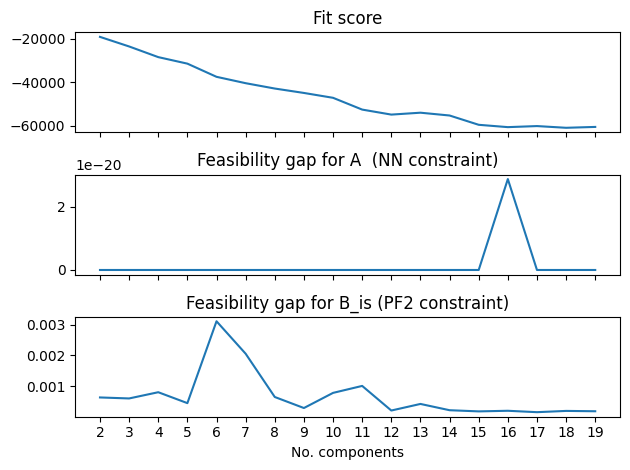

In [ ]:
fig, axes = plt.subplots(3, 1, tight_layout=True, sharex=True)
axes[0].set_title("Fit score")
axes[0].plot(range(2, 20), fit_scores)
axes[1].set_title("Feasibility gap for A  (NN constraint)")
axes[1].plot(range(2, 20), A_gaps)
axes[2].set_title("Feasibility gap for B_is (PF2 constraint)")
axes[2].plot(range(2, 20), B_gaps)
axes[2].set_xlabel("No. components")
axes[2].set_xticks(range(2, 20))
plt.show()

In [ ]:
(selected_cmf.factors)

[array([[ 1.76071628e-01,  1.91844194e+00,  2.00923107e+00,
          7.86558211e-01,  1.95656320e+00,  4.31913434e-01,
          1.82769197e+00,  1.36927143e+00,  1.45963461e+00,
          1.80224154e+00,  5.19771001e-01,  1.63950561e+00,
          1.90390761e+00,  1.33734594e+00,  3.17571202e-02,
          2.12071571e+00,  5.55979217e-01,  1.84697568e+00,
          1.91682097e+00],
        [ 4.07706839e-01,  1.42498550e-01,  5.77287833e-02,
          4.51489926e-01,  3.26415097e-02,  1.92231678e+00,
          9.75744990e-03,  7.60790682e-03,  5.54113592e-02,
          1.82911670e-02,  6.41408046e-01,  1.97814740e-02,
          1.10862017e-01, -4.48795576e-02,  8.95014067e-01,
          1.60284846e-02,  8.11098382e-01,  1.17745000e-02,
          5.49246971e-02],
        [ 3.48485855e-01,  1.45622549e-03, -1.30745355e-03,
          2.42476288e-02, -7.43884602e-04,  1.16319009e-01,
          1.53288984e-04, -1.30413692e-03, -2.03076453e-03,
          1.23128860e-03,  7.60792305e-03, -4.

In [ ]:
def get_stacked_CP_tensor(cmf):
    weights, factors = cmf
    A, B_is, C = factors

    stacked_cp_tensor = (weights, (A, np.concatenate(B_is, axis=0), C))
    return stacked_cp_tensor


fms, permutation = factor_match_score(
    get_stacked_CP_tensor(cmf), get_stacked_CP_tensor(selected_cmf), consider_weights=False, return_permutation=True
)
print(f"Factor match score: {fms}")

Factor match score: 1.0000000000000362


In [ ]:
# Function to save lists to CSV files
def save_to_csv(filename, data, header):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)  # Add headers if needed
        writer.writerows([[value] for value in data])  # Write each value in a new row

# Saving the lists to CSV files
save_to_csv('fit_scores.csv', fit_scores, ['Fit Scores'])
save_to_csv('B_gaps.csv', B_gaps, ['B Gaps'])
save_to_csv('A_gaps.csv', A_gaps, ['A Gaps'])

# Saving selected_cmf, selected_diagnostics, and lowest_error with pickle
with open('selected_data.pkl', 'wb') as file:
    pickle.dump({
        'selected_cmf': selected_cmf,
        'selected_diagnostics': selected_diagnostics,
        'lowest_error': lowest_error
    }, file)

print("Data saved successfully.")


Data saved successfully.


In [8]:
# Function to load lists from CSV files
def load_from_csv(filename):
    data = []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            data.append(row[0])  # Assuming one value per row
    return data

# Reloading the data from CSV files
fit_scores = load_from_csv('fit_scores.csv')
B_gaps = load_from_csv('B_gaps.csv')
A_gaps = load_from_csv('A_gaps.csv')

# Reloading selected_data from pickle file
with open('selected_data.pkl', 'rb') as file:
    selected_data = pickle.load(file)
    selected_cmf = selected_data['selected_cmf']
    selected_diagnostics = selected_data['selected_diagnostics']
    lowest_error = selected_data['lowest_error']

print("Data loaded successfully.")

Data loaded successfully.


/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyw

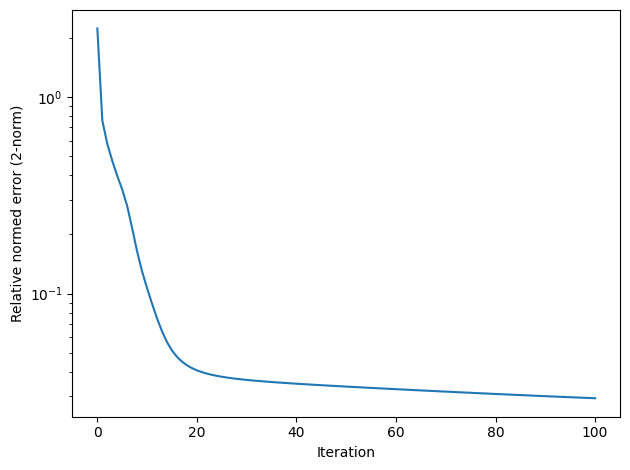

In [9]:
fig, ax = plt.subplots(tight_layout=True)
ax.semilogy(selected_diagnostics.rec_errors)
plt.xlabel("Iteration")
plt.ylabel("Relative normed error (2-norm)")
plt.show()

In [10]:
selected_cmf.factors

[array([[ 1.76071628e-01,  1.91844194e+00,  2.00923107e+00,
          7.86558211e-01,  1.95656320e+00,  4.31913434e-01,
          1.82769197e+00,  1.36927143e+00,  1.45963461e+00,
          1.80224154e+00,  5.19771001e-01,  1.63950561e+00,
          1.90390761e+00,  1.33734594e+00,  3.17571202e-02,
          2.12071571e+00,  5.55979217e-01,  1.84697568e+00,
          1.91682097e+00],
        [ 4.07706839e-01,  1.42498550e-01,  5.77287833e-02,
          4.51489926e-01,  3.26415097e-02,  1.92231678e+00,
          9.75744990e-03,  7.60790682e-03,  5.54113592e-02,
          1.82911670e-02,  6.41408046e-01,  1.97814740e-02,
          1.10862017e-01, -4.48795576e-02,  8.95014067e-01,
          1.60284846e-02,  8.11098382e-01,  1.17745000e-02,
          5.49246971e-02],
        [ 3.48485855e-01,  1.45622549e-03, -1.30745355e-03,
          2.42476288e-02, -7.43884602e-04,  1.16319009e-01,
          1.53288984e-04, -1.30413692e-03, -2.03076453e-03,
          1.23128860e-03,  7.60792305e-03, -4.

In [ ]:
selected_cmf, selected_diagnostics, lowest_error

((weights, factors) : rank-19 CoupledMatrixFactorization of shape ((414234, 12), (26210, 12), (137, 12)),
 DiagnosticMetrics(rec_errors=[2.2333933610902155, 0.7586362462181986, 0.5775249369979807, 0.47315749473921287, 0.39694979606284714, 0.33842518958249856, 0.2783856554652124, 0.21475014236148235, 0.16304391337643911, 0.1292338910349839, 0.10623764643770402, 0.08857741568782088, 0.07463063686561602, 0.06409330698903813, 0.05653877486506196, 0.05127751039349065, 0.04761067463357238, 0.04501081479044014, 0.04312157896435775, 0.04171266246727622, 0.040634514105042374, 0.039789994134678215, 0.039112175926935146, 0.03855675227901726, 0.03809267804412693, 0.03769721991159527, 0.0373549120522397, 0.03705473146536466, 0.03678788259885789, 0.03654706759872371, 0.03632774556017861, 0.036125898144666616, 0.0359386526873889, 0.0357633895366482, 0.03559801003996545, 0.03544092064161422, 0.03529100650137721, 0.03514725334447479, 0.03500863913122106, 0.03487483846076945, 0.03474508846330957, 0.0346

In [55]:
# selected_cmf, rrbs_indices, rna_indices, metabo_indices, rrbs_matrix_filtered
# Load indices
rrbs_indices = pd.read_csv("rrbs_indices.csv", index_col=0)
rna_indices = pd.read_csv("rna_indices.csv", index_col=0)
metabo_indices = pd.read_csv("metabo_indices.csv", index_col=0)

# Decompose the selected CMF into weights and factor matrices
weights, (A, B_is, C) = selected_cmf
if weights is None:
    weights = np.ones(A.shape[1])  # Default to uniform weights if not provided

# Calculate norms and order components
norms = (
    np.linalg.norm(A, axis=0)
    * np.linalg.norm(B_is[0], axis=0)
    * np.linalg.norm(C, axis=0)
)
order = np.argsort(-weights * norms)  # Order components by weighted norms (descending)

# Process matrices A, B_is, and C
A = pd.DataFrame(
    np.maximum(0, A[:, order]),
    index=["RRBS", "RNA-seq", "Metabolomics"],
    columns=[f"{i+1}" for i in range(A.shape[1])]
)

B_is = [
    pd.DataFrame(
        np.maximum(0, B_is[0][:, order]),
        index=rrbs_indices,
        columns=[f"{i+1}" for i in range(B_is[0].shape[1])]
    ),
    pd.DataFrame(
        np.maximum(0, B_is[1][:, order]),
        index=rna_indices,
        columns=[f"{i+1}" for i in range(B_is[1].shape[1])]
    ),
    pd.DataFrame(
        np.maximum(0, B_is[2][:, order]),
        index=metabo_indices,
        columns=[f"{i+1}" for i in range(B_is[2].shape[1])]
    ),
]

C = pd.DataFrame(
    np.maximum(0, C[:, order]),
    index=rrbs_matrix_filtered.columns,
    columns=[f"{i+1}" for i in range(C.shape[1])]
)


In [74]:
import plotly.io as pio

# Visualize matrix C (time-resolved components)
C_melted = C.reset_index().melt(
    id_vars="index", var_name="Component", value_name="Value"
)
C_melted.rename(columns={"index": "Samples"}, inplace=True)

fig1 = px.line(
    C_melted,
    x="Samples",
    y="Value",
    color="Component",
    #facet_row="Component",
    hover_data="Samples",
    title="Sample-wise Component Visualization (C^i)",
    width=1400,  # Set plot width
    height=400,  # Set plot height
)
fig1.update_layout(
    title_font_size=25,  # Increase title font size
    xaxis_title_font_size=18,  # Increase x-axis title font size
    yaxis_title_font_size=20,  # Increase y-axis title font size
    legend_font_size=20,  # Increase legend font size
    font=dict(size=20),  # Increase overall font size
)
# Save the first plot
pio.write_image(fig1, "collective_factor_plot_C.png", format="png", width=1400, height=400)
fig1.show()

# Visualize matrix A (component strengths in data sources)
A_melted = A.reset_index().melt(
    id_vars="index", var_name="Component", value_name="Value"
)
A_melted.rename(columns={"index": "Source"}, inplace=True)
A_melted["Component"] = A_melted["Component"].astype(str)  # Ensure discrete colormap

fig2 = px.bar(
    A_melted,
    x="Source",
    y="Value",
    color="Component",
    facet_row="Component",
    title="Component Strengths in Data Sources (D^i)",
    width=800,  # Set plot width
    height=800,  # Set plot height
)
fig2.update_layout(
    title_font_size=25,  # Increase title font size
    xaxis_title_font_size=18,  # Increase x-axis title font size
    yaxis_title_font_size=20,  # Increase y-axis title font size
    legend_font_size=20,  # Increase legend font size
    font=dict(size=20),  # Increase overall font size
)
# Save the second plot
pio.write_image(fig2, "weights_plot_D.png", format="png", width=800, height=800)
fig2.show()




In [ ]:
weights, (A, B_is, C) = selected_cmf

In [19]:
df_1 = pd.DataFrame(B_is[0])
df_1

,Component 1,Component 2,Component 3,Component 4
"(GL456368.1_19257,)",0.060648,0.000000,0.000000,0.000000
"(GL456381.1_5881,)",0.013534,0.072479,0.043976,0.039641
"(1_3091100,)",0.022079,0.038214,0.063971,0.053610
"(1_3091114,)",0.019149,0.048975,0.066269,0.055929
"(1_3091195,)",0.003742,0.145661,0.000000,0.000000
...,...,...,...,...
"(2_39028657,)",0.007078,0.083899,0.036795,0.040416
"(2_39080397,)",0.000000,0.000000,0.000000,0.000000
"(2_39080686,)",0.000000,0.000000,0.000000,0.000000
"(2_39103306,)",0.119809,0.000000,0.000000,0.000000


In [20]:
df_2 = pd.DataFrame(B_is[1])
df_2

,Component 1,Component 2,Component 3,Component 4
"(Gnai3,)",0.238119,9.460662e-05,0.000047,0.234947
"(Cdc45,)",1.671356,0.000000e+00,0.000033,0.357895
"(H19,)",0.000009,4.676383e-01,0.000005,0.000000
"(Scml2,)",0.900832,4.957411e-05,0.000025,1.080951
"(Narf,)",0.000022,6.190658e-05,1.458665,0.000000
...,...,...,...,...
"(Rn7sk,)",0.000002,1.311409e-01,0.000001,0.000001
"(Gm55635,)",0.000000,2.467668e-06,0.000002,0.000006
"(Gm55944,)",0.000010,1.810556e-05,0.799565,0.000015
"(Gm55307,)",0.000000,0.000000e+00,0.000000,0.000000


In [21]:
df_3 = pd.DataFrame(B_is[2])
df_3

,Component 1,Component 2,Component 3,Component 4
"(2-Aminobutyrate,)",0.000000,0.000000,0.000000,0.000000
"(2-HG,)",8.994370,0.000391,0.000000,9.951269
"(2-Oxoadipate,)",0.000778,0.000814,0.000000,0.000000
"(3-Phosphoglycerate,)",0.000001,0.000000,0.000000,0.000000
"(4-Hydroxyphenyllactate,)",0.000000,15.894417,0.000359,0.001151
...,...,...,...,...
"(Uracil,)",0.000026,0.000000,0.000028,0.000000
"(Uridine,)",0.000000,0.000000,0.800798,0.000000
"(UTP,)",0.000000,0.000000,0.000000,0.000000
"(Valine,)",0.000000,18.953903,0.000486,0.001228


/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later

/opt

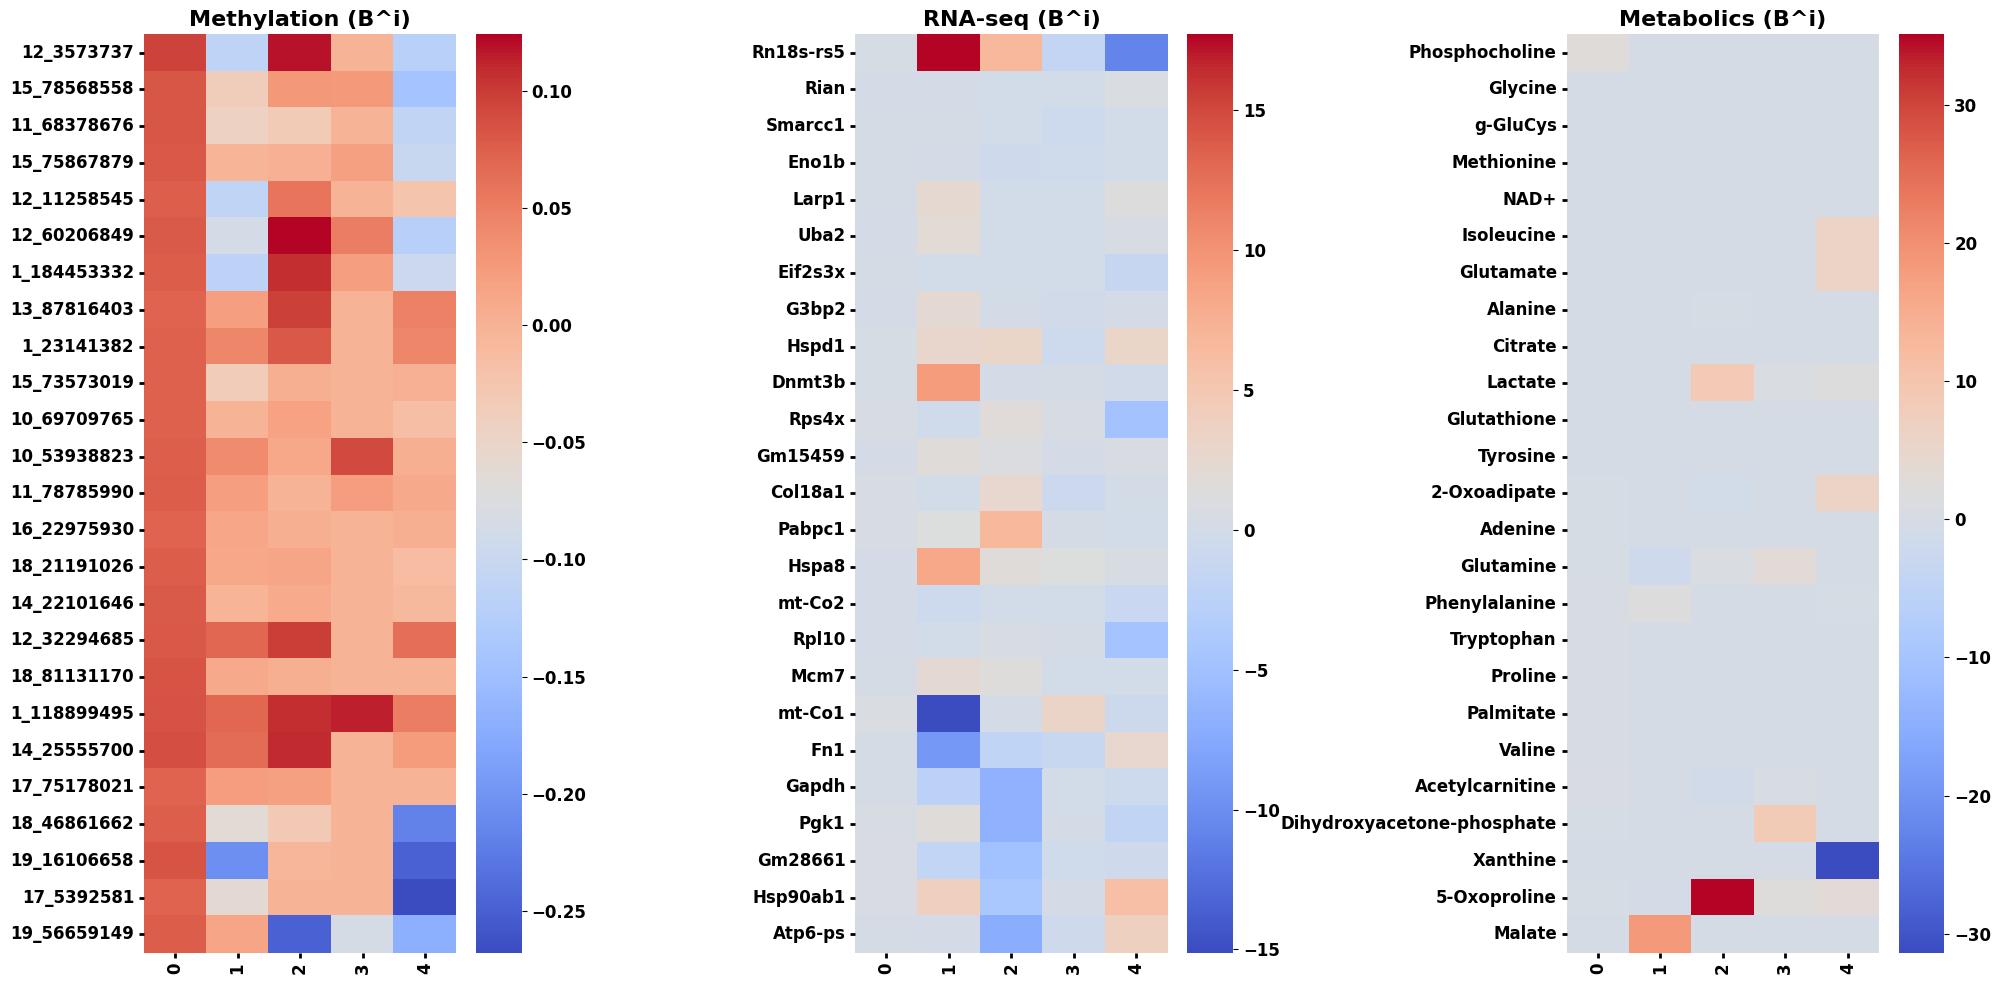

In [ ]:
# B matrices - Unique Factor Matrices
# Load indices
rrbs_indices = pd.read_csv("rrbs_indices.csv", index_col=0)
rna_indices = pd.read_csv("rna_indices.csv", index_col=0)
metabo_indices = pd.read_csv("metabo_indices.csv", index_col=0)

# For Methylation
methylation_data = pd.DataFrame(selected_cmf.factors[1][0])  # Convert to DataFrame
methylation_data.index = rrbs_indices.loc[methylation_data.index].values.flatten()  # Match indices
methylation_data = methylation_data.iloc[:, :5]
methylation_sorted = methylation_data.sort_values(by=methylation_data.columns[0], axis=0, ascending=False)  # Sort based on first column
top_methylation = methylation_sorted.head(25)

# For RNA-seq
rna_data = pd.DataFrame(selected_cmf.factors[1][1])  # Convert to DataFrame
rna_data.index = rna_indices.loc[rna_data.index].values.flatten()  # Match indices
rna_data = rna_data.iloc[:, :5]
rna_sorted = rna_data.sort_values(by=rna_data.columns[0], axis=0, ascending=False)  # Sort based on first column
top_rna = rna_sorted.head(25)

# For Metabolics
metabolics_data = pd.DataFrame(selected_cmf.factors[1][2])  # Convert to DataFrame
metabolics_data.index = metabo_indices.loc[metabolics_data.index].values.flatten()  # Match indices
metabolics_data = metabolics_data.iloc[:, :5]
metabolics_sorted = metabolics_data.sort_values(by=metabolics_data.columns[0], axis=0, ascending=False)  # Sort based on first column
top_metabolics = metabolics_sorted.head(25)

# Example function to replace hierarchical clustering with k-Means
def kmeans_clustermap(data, n_clusters, cmap="coolwarm", ax=None, title=""):

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    data_with_clusters = pd.DataFrame(data, index=data.index, columns=data.columns)
    data_with_clusters['Cluster'] = cluster_labels

    sorted_data = data_with_clusters.sort_values(by='Cluster').drop('Cluster', axis=1)

    sns.heatmap(
        sorted_data,
        cmap=cmap,
        cbar=True,
        ax=ax,
        annot=False,
        xticklabels=True,
        yticklabels=True,
    )
    ax.set_title(title, fontsize=16, weight ="bold")  # Bold and larger title
    ax.tick_params(axis='x', labelsize=12, labelrotation=90, width=2)
    ax.tick_params(axis='y', labelsize=12, width=2)


# Create a shared figure with subplots for the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Methylation Clustermap
kmeans_clustermap(top_methylation, n_clusters=4, cmap="coolwarm", ax=axes[0], title="Methylation (B^i)")

# RNA-seq Clustermap
kmeans_clustermap(top_rna, n_clusters=4, cmap="coolwarm", ax=axes[1], title="RNA-seq (B^i)")

# Metabolics Clustermap
kmeans_clustermap(top_metabolics, n_clusters=4, cmap="coolwarm", ax=axes[2], title="Metabolics (B^i)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

